In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [2]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [126]:
# hyp_res = parse_results('grid_search_results/hyp_broad_search_50_cutoff.txt')
# euc_res = parse_results('grid_search_results/tom_euc_overall-liking_400.txt')

both_res = parse_results('grid_search_results/both_small-dataset_100.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]

In [127]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((10, 5, 100), (10, 5, 100))

In [128]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [129]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[0, 1, 2, 4, 8]
[128, 256]
[0.02]
[0.005]


In [130]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [131]:
num_hidden_layers.shape, layer_size.shape

((10,), (10,))

In [132]:
hyp_values.mean(axis=1)[:,-1].shape

(10,)

0.07734022535945456 -0.04298750798542696
0.0994400408608038 0.09234154523928223


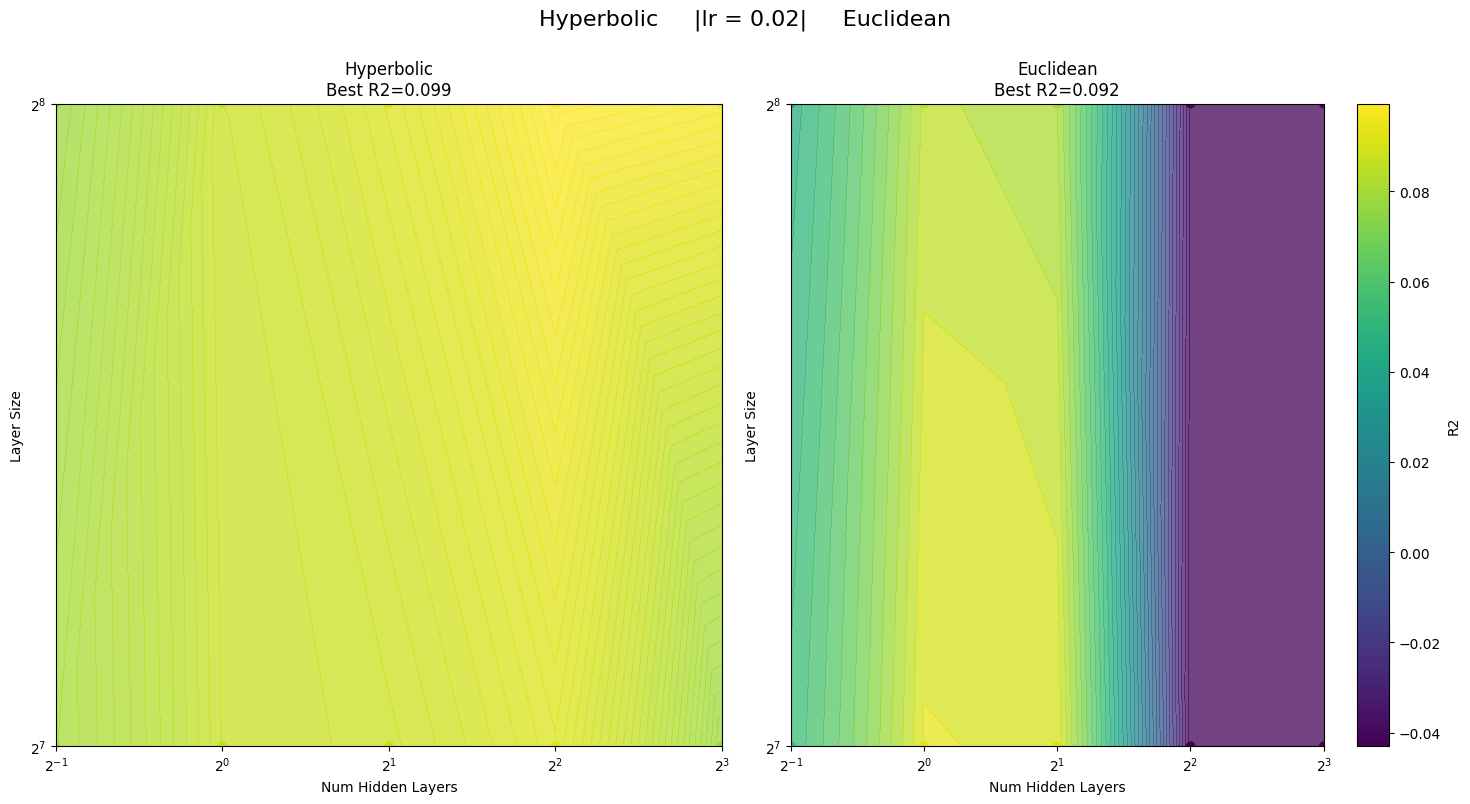

In [134]:
for i, lr in enumerate(LR):
    hyp_data = hyp_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i]
    euc_data = euc_values.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i]

    min_val = min(np.min(hyp_data), np.min(euc_data))
    max_val = max(np.max(hyp_data), np.max(euc_data))

    print(np.min(hyp_data), np.min(euc_data))
    print(np.max(hyp_data), np.max(euc_data))

    cmap = plt.cm.viridis
    norm = Normalize(vmin=min_val, vmax=max_val)

    num_hidden_layers_adjust = num_hidden_layers.astype(float)
    num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

    mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


    plt.figure(figsize=(15,8))
    plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

    plt.subplot(121)
    plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

    plt.title(f'Hyperbolic\nBest R2={np.max(hyp_data):.3f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)


    plt.subplot(122)
    euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
    euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
    plt.colorbar(euc_scatter, label='R2')


    plt.title(f'Euclidean\nBest R2={np.max(euc_data):.3f}')
    plt.xlabel('Num Hidden Layers')
    plt.ylabel('Layer Size')

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)

    plt.tight_layout()
    plt.show()

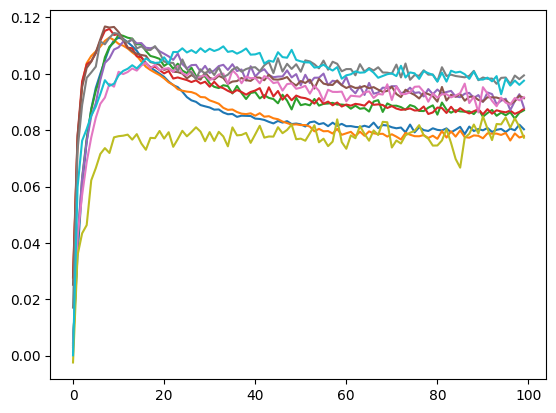

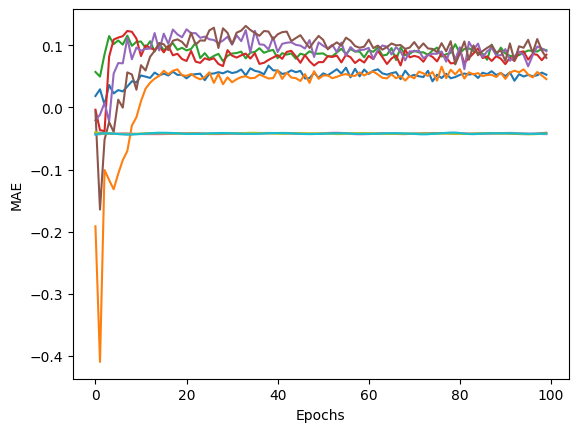

In [136]:
for run in hyp_values.mean(axis=1):
    plt.plot(run)
    # plt.plot(run[20:])

# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1):
    plt.plot(run)
    # plt.plot(run[20:])

# plt.title('Hyperbolic Strawberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.yscale('log')
plt.show()
